## Imports

In [1]:
import torch
from datasets.nsd import NaturalScenesDataset
from datasets.nsd_features import NSDFeaturesDataset
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.img_utils import save_images
from sklearn.metrics import pairwise_distances
from sklearn import manifold
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from utils.nsd_utils import parse_rois, get_roi_indices
import io
import torch.nn.functional as F
from tqdm import tqdm
import cv2

/home/diego/miniconda3/envs/braindive/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Load data

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

subject = 1
data_root = './data/NSD'
roi = [
    "PPA",
]
roi_desc = roi[0]
hemisphere = 'right'
seed = 0

nsd = NaturalScenesDataset(
    root=data_root,
    subject=subject,
    partition="train",
    hemisphere=hemisphere,
    roi=roi,
)

feature_extractor_type = "clip_2_0"
metric = 'cosine'
n_neighbors = 0

dataset = NSDFeaturesDataset(
    nsd=nsd,
    feature_extractor_type=feature_extractor_type,
    predict_average=False,
    metric=metric,
    n_neighbors=n_neighbors,
    seed=seed,
    device=device,
    keep_features=True,
)
del nsd

# Load index and inverted index
f = os.path.join(data_root, f'subj{subject:02d}/index_train.json')
index = json.load(open(f, 'r'))
f = os.path.join(data_root, f'subj{subject:02d}/inverted_index_train.json')
inv_index = json.load(open(f, 'r'))

Computing targets...: 100%|██████████| 9841/9841 [00:06<00:00, 1626.46it/s]


Computing low dimensional representation...
Done.


In [23]:
folder = './exp'
filenames = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.npy')]

acts = []
for f in filenames:
    act = np.load(f)[:,0]
    acts.append(act)
acts = np.array(acts)

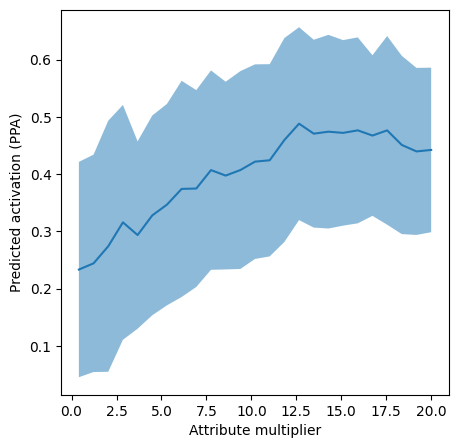

In [24]:
high_ind = np.where(np.linspace(-20,20,50) <= 0)[0][::-1]

plt.figure(figsize=(5,5))
plt.plot(-np.linspace(-20,20,50)[high_ind], acts.mean(-1).mean(0)[high_ind])
plt.fill_between(-np.linspace(-20,20,50)[high_ind], acts.mean(-1).mean(0)[high_ind] - acts.mean(-1).std(0)[high_ind], acts.mean(-1).mean(0)[high_ind] + acts.mean(-1).std(0)[high_ind], alpha=0.5)
plt.xlabel('Attribute multiplier')
plt.ylabel('Predicted activation (PPA)')
plt.show()

In [25]:
locs = dataset.nsd.fs_coords[dataset.nsd.fs_indices]
ind = dataset.nsd.roi_indices
locs = locs[ind]

acts = acts.mean(0)[high_ind]

images = []
for idx in range(len(acts)):
    f = plt.figure(figsize=(5, 5))
    plt.scatter(locs[:, 0], locs[:, 1], c=acts[idx], cmap='RdBu_r', vmin=acts.min(), vmax=acts.max())
    plt.axis('off')
    plt.title(f'Darkness mult: {-np.linspace(-20,20,50)[idx]:.2f}, avg: {acts[idx].mean():.2f}')
    plt.colorbar(label='Predicted activation')
    plt.tight_layout()
    buf = io.BytesIO()
    f.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    plt.close(f)
    images.append(img)

images = images
images[0].save(f'acts.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

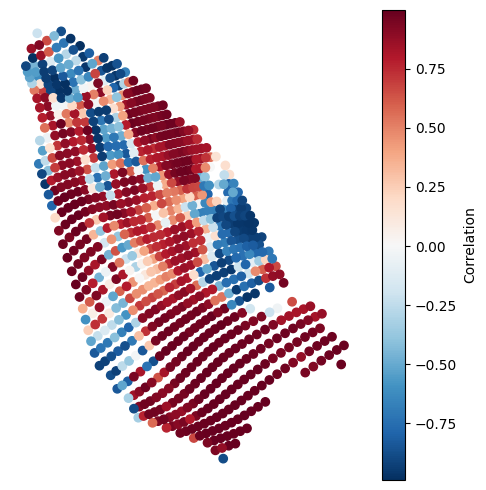

In [26]:
corrs = []

for v in acts.T:
    corr = np.corrcoef(v, -np.linspace(-20,20,50)[high_ind])[0,1]
    corrs.append(corr)

f = plt.figure(figsize=(5, 5))
plt.scatter(locs[:, 0], locs[:, 1], c=corrs, cmap='RdBu_r')
plt.axis('off')
plt.colorbar(label='Correlation')
plt.tight_layout()
plt.show()

## Saving direction vectors

### Activations (whole dataset)

In [3]:
roi_axis = dataset.targets.mean(axis=1).numpy()

model = LinearRegression(fit_intercept=False).fit(roi_axis.reshape(-1, 1), dataset.features - dataset.features.mean(axis=0))
directiona1_vector = model.coef_[:,0]
directiona1_vector = directiona1_vector / np.linalg.norm(model.coef_[:,0])

os.makedirs('./direction_vectors', exist_ok=True)
np.save(f'./direction_vectors/{subject}_{roi_desc}_{hemisphere}.npy', directiona1_vector)

### Low-level attributes

In [35]:
properties = {}

for i in range(len(dataset)):

    img = Image.open(os.path.join(data_root, dataset.nsd.df.iloc[i]["filename"]))
    img_hsv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)

    l = img_hsv[:,:,2].mean()
    s = img_hsv[:,:,1].mean()
    w = np.abs(img_hsv[:,:,0] - 60).mean()
    c = img_hsv[:,:,2].max() - img_hsv[:,:,2].min()

    properties.setdefault('lightness', [])
    properties.setdefault('saturation', [])
    properties.setdefault('warmth', [])
    properties.setdefault('contrast', [])

    properties['lightness'].append(l)
    properties['saturation'].append(s)
    properties['warmth'].append(w)
    properties['contrast'].append(c)

In [37]:
for k, v in properties.items():
    properties[k] = np.array(v)
    model = LinearRegression(fit_intercept=False).fit(dataset.features - dataset.features.mean(axis=0), properties[k].reshape(-1, 1))
    directiona1_vector = model.coef_[0]
    directiona1_vector = directiona1_vector / np.linalg.norm(model.coef_[0])
    np.save(f'./direction_vectors/{subject}_{k}_rev.npy', directiona1_vector)

### High-level attributes

In [5]:
df = pd.read_csv('attributes.tsv', sep='\t')

for description in df['description']:
    idx = df[df.description == description].index[0]
    x0 = np.load(f'attribute_vectors/{idx}_0.npy')
    x1 = np.load(f'attribute_vectors/{idx}_1.npy')
    attribute_vector = x1 - x0
    attribute_vector /= np.linalg.norm(attribute_vector)
    np.save(f'./direction_vectors/{description}.npy', attribute_vector)

### Activations (trajectory)

In [13]:
roi_axis = dataset.targets.mean(axis=1).numpy()

subsets = np.array_split(np.argsort(roi_axis), 10)

directiona1_vectors = []
for i, subset in enumerate(subsets):
    model = LinearRegression(fit_intercept=False).fit(roi_axis[subset].reshape(-1, 1), dataset.features[subset] - dataset.features[subset].mean(axis=0))
    directiona1_vector = model.coef_[:,0]
    directiona1_vector = directiona1_vector / np.linalg.norm(model.coef_[:,0])
    directiona1_vectors.append(directiona1_vector)
    i = str(i).zfill(4)
    np.save(f'./direction_vectors/{subject}_{roi_desc}_{hemisphere}_subset{i}.npy', directiona1_vector)

### Get source images

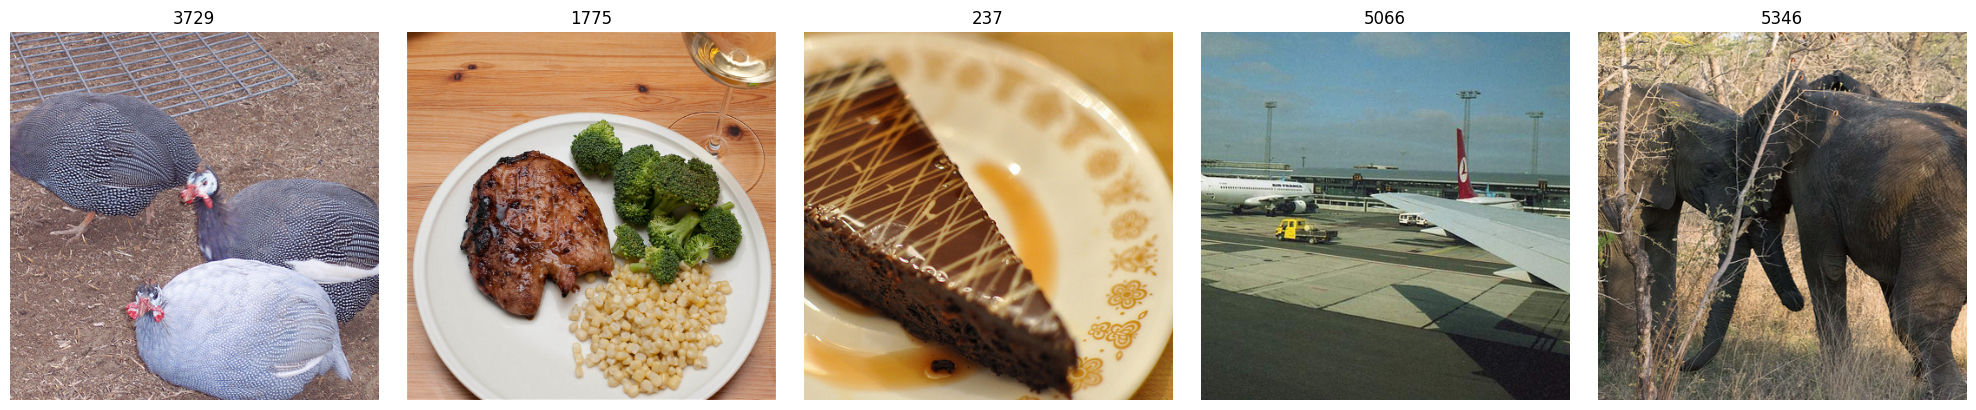

In [101]:
std = 0.3
idx = np.where((roi_axis > roi_axis.mean() - std * roi_axis.std()) & (roi_axis < roi_axis.mean() + std * roi_axis.std()))[0]

random_choice = np.random.choice(idx, 5, replace=False)

f, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(Image.open(os.path.join(data_root, dataset.nsd.df.iloc[random_choice[i]]["filename"])))
    ax.axis('off')
    ax.set_title(random_choice[i])
plt.tight_layout()
plt.show()

### Visualize results

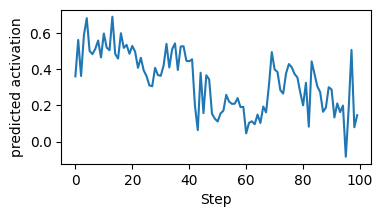

In [41]:
arr =np.load('outputs/car/1_PPA_right/1_lightness_rev/0/acts.npy')

plt.figure(figsize=(4,2))
plt.plot(arr[::-1])
plt.xlabel('Step')
plt.ylabel('predicted activation')
plt.show()

In [39]:
for category in ['car', 'food', 'kitchen', 'player', 'zebra']:

    folder = f'outputs/{category}/1_PPA_right/1_lightness_rev/0'
    filenames = np.array([f for f in os.listdir(folder) if f.endswith(".png")])
    filenames_float = [float(f.replace(".png", "")) for f in filenames]
    filenames = filenames[np.argsort(filenames_float)]

    images = [Image.open(os.path.join(folder, f)).resize((384, 384)) for f in filenames][::-1]

    images[0].save(f'{category}.gif', save_all=True, append_images=images[1:], optimize=False, duration=20, loop=0)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/food/1_PPA_right/1_lightness_rev/0'